In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/Thesis/UpdatedData.zip

In [5]:
import pathlib
data_dir = "/content/Updated Data/"
data_dir = pathlib.Path(data_dir)
print(data_dir)

/content/Updated Data


In [6]:
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

9287


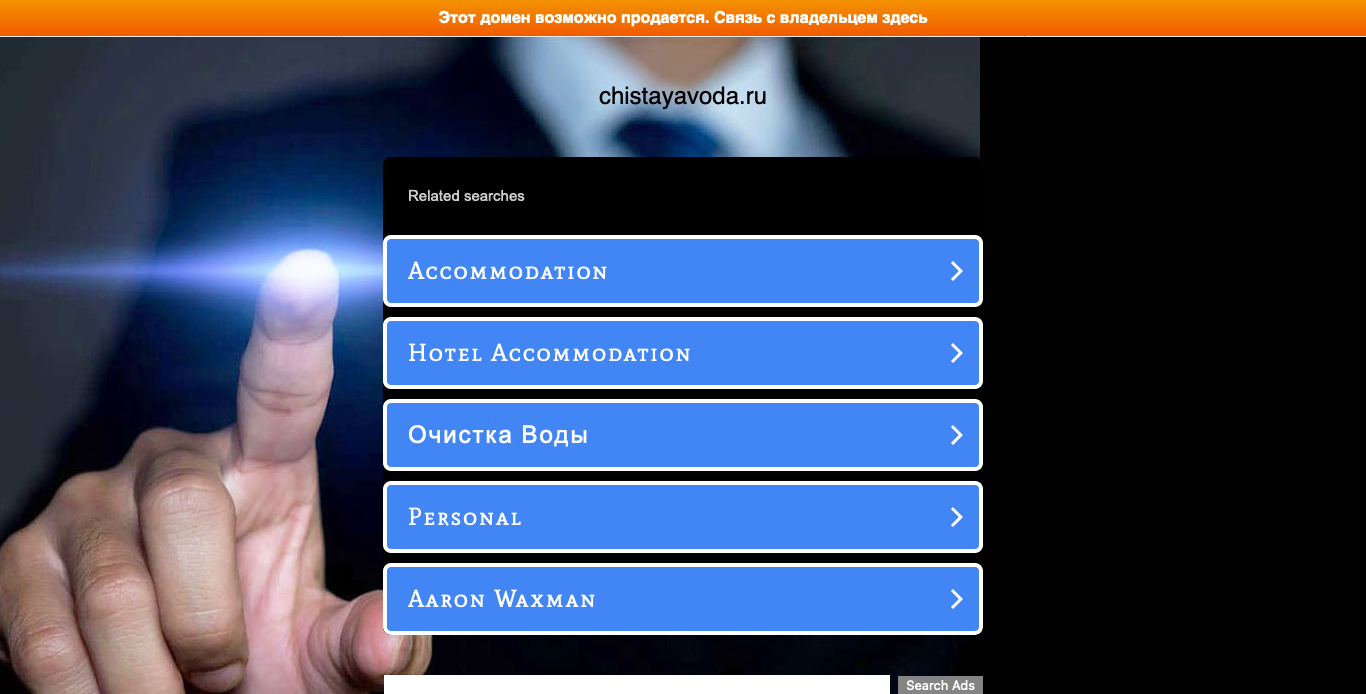

In [7]:
malicious = list(data_dir.glob('malicious/*'))
PIL.Image.open(str(malicious[9]))

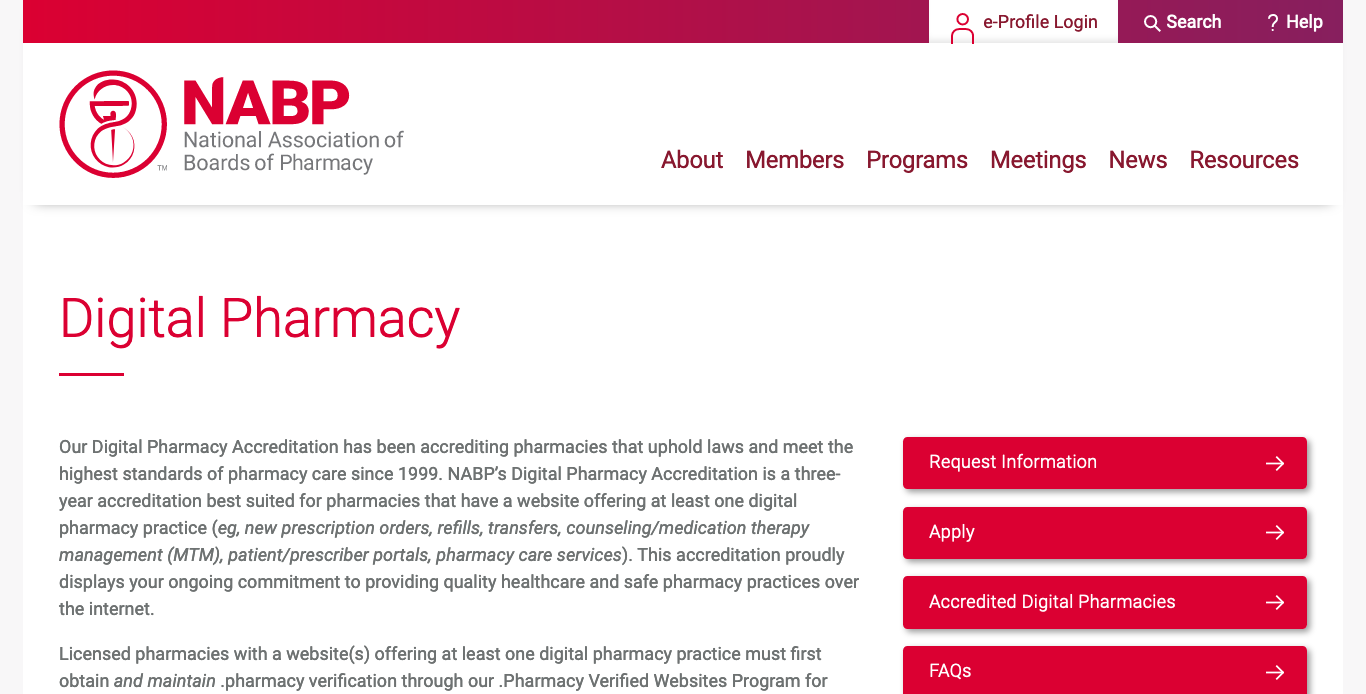

In [8]:
benign = list(data_dir.glob('benign/*'))
PIL.Image.open(str(benign[1]))

In [9]:
batch_size = 32
img_height = 180
img_width = 180

In [10]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9287 files belonging to 2 classes.
Using 7430 files for training.


In [11]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9287 files belonging to 2 classes.
Using 1857 files for validation.


In [12]:
class_names = train_ds.class_names
print(class_names)

['benign', 'malicious']


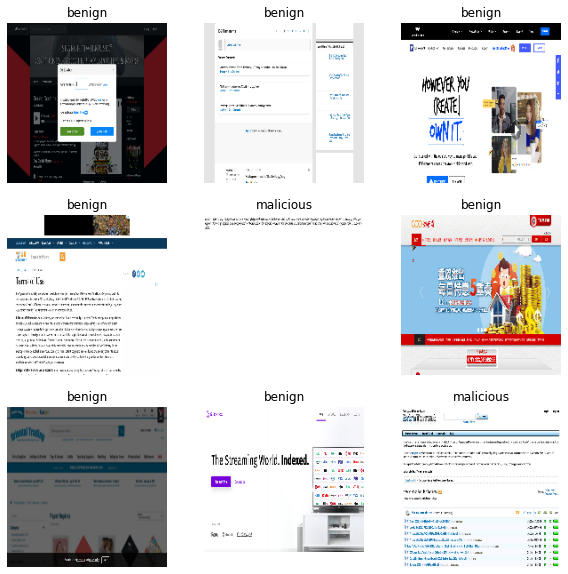

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [14]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [16]:
normalization_layer = layers.Rescaling(1./255)

In [17]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 1.0


In [18]:
num_classes = 2

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [19]:
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

In [23]:
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
233/233 [==============================] - 216s 926ms/step - loss: 0.0265 - accuracy: 0.9898 - val_loss: 0.0421 - val_accuracy: 0.9865
Epoch 2/20
233/233 [==============================] - 216s 926ms/step - loss: 0.0238 - accuracy: 0.9907 - val_loss: 0.0654 - val_accuracy: 0.9828
Epoch 3/20
233/233 [==============================] - 215s 924ms/step - loss: 0.0492 - accuracy: 0.9818 - val_loss: 0.0619 - val_accuracy: 0.9817
Epoch 4/20
233/233 [==============================] - 216s 929ms/step - loss: 0.0297 - accuracy: 0.9883 - val_loss: 0.0592 - val_accuracy: 0.9855
Epoch 5/20
233/233 [==============================] - 217s 931ms/step - loss: 0.0305 - accuracy: 0.9891 - val_loss: 0.0742 - val_accuracy: 0.9812
Epoch 6/20
233/233 [==============================] - 218s 938ms/step - loss: 0.0263 - accuracy: 0.9899 - val_loss: 0.0547 - val_accuracy: 0.9849
Epoch 7/20
233/233 [==============================] - 216s 926ms/step - loss: 0.0251 - accuracy: 0.9908 - val_loss: 0.0787 -

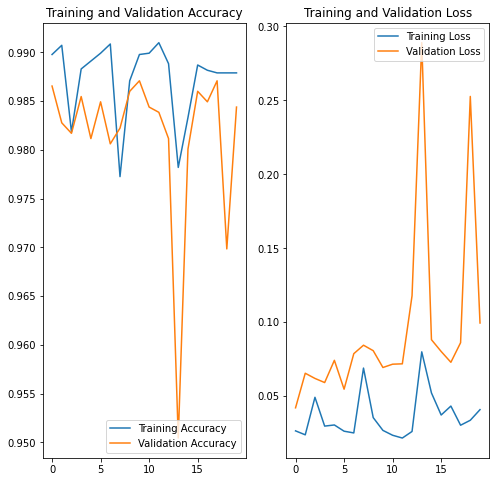

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()